In [1]:
from project_functions import *

In [2]:
train_data_path="train_images/"
train_file = "train.csv"

image_size = 150

In [3]:
x_train_val,x_test,y_train_val,y_test = preprocessing_data(train_data_path, train_file, image_size)

DenseNet training with 3-Fold Cross Validation.
Epoch 1/15
55/55 [==============================] - 29s 281ms/step - loss: 0.5299 - acc: 0.7517 - val_loss: 0.6798 - val_acc: 0.6173
Epoch 2/15
55/55 [==============================] - 10s 182ms/step - loss: 0.2571 - acc: 0.8918 - val_loss: 0.3942 - val_acc: 0.8214
Epoch 3/15
55/55 [==============================] - 10s 183ms/step - loss: 0.1880 - acc: 0.9186 - val_loss: 0.3247 - val_acc: 0.8571
Epoch 4/15
55/55 [==============================] - 10s 187ms/step - loss: 0.1329 - acc: 0.9436 - val_loss: 0.2911 - val_acc: 0.8571
Epoch 5/15
55/55 [==============================] - 10s 187ms/step - loss: 0.1086 - acc: 0.9544 - val_loss: 0.2605 - val_acc: 0.8827
Epoch 6/15
55/55 [==============================] - 11s 204ms/step - loss: 0.0837 - acc: 0.9675 - val_loss: 0.2351 - val_acc: 0.8980
Epoch 7/15
55/55 [==============================] - 13s 238ms/step - loss: 0.0853 - acc: 0.9647 - val_loss: 0.2079 - val_acc: 0.9133
Epoch 8/15
55/55 [===

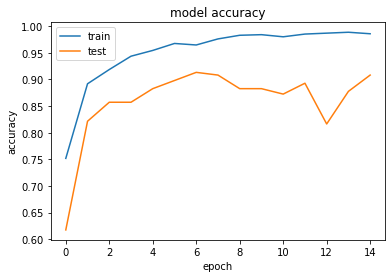

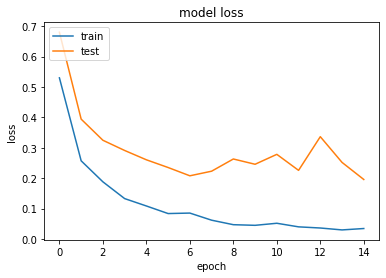

The highest validation acc is 0.9132652878761292
DenseNet 3-Fold CV:
Average Acc: 0.8700
Average Precision: 0.7558
Average recall: 0.8471
Average F1 Score: 0.7754 

Epoch 1/15
55/55 [==============================] - 26s 330ms/step - loss: 0.5324 - acc: 0.7427 - val_loss: 0.5203 - val_acc: 0.7857
Epoch 2/15
55/55 [==============================] - 13s 245ms/step - loss: 0.2615 - acc: 0.8828 - val_loss: 0.3568 - val_acc: 0.8571
Epoch 3/15
55/55 [==============================] - 14s 251ms/step - loss: 0.1760 - acc: 0.9294 - val_loss: 0.3494 - val_acc: 0.8622
Epoch 4/15
55/55 [==============================] - 14s 256ms/step - loss: 0.1399 - acc: 0.9442 - val_loss: 0.3316 - val_acc: 0.8571
Epoch 5/15
55/55 [==============================] - 14s 248ms/step - loss: 0.1010 - acc: 0.9590 - val_loss: 0.2595 - val_acc: 0.8827
Epoch 6/15
55/55 [==============================] - 14s 248ms/step - loss: 0.0867 - acc: 0.9687 - val_loss: 0.2650 - val_acc: 0.8827
Epoch 7/15
55/55 [===================

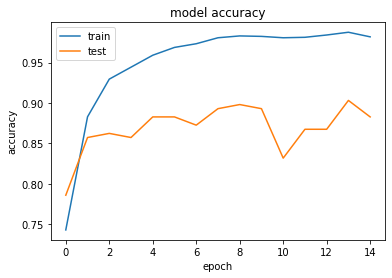

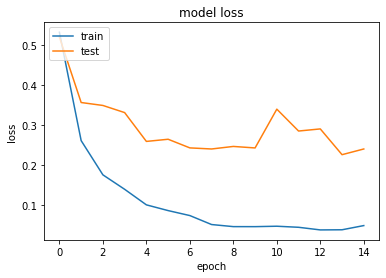

The highest validation acc is 0.9030612111091614
DenseNet 3-Fold CV:
Average Acc: 0.8715
Average Precision: 0.7661
Average recall: 0.8363
Average F1 Score: 0.7844 

Epoch 1/15
55/55 [==============================] - 22s 260ms/step - loss: 0.5225 - acc: 0.7581 - val_loss: 0.5582 - val_acc: 0.7194
Epoch 2/15
55/55 [==============================] - 14s 248ms/step - loss: 0.2656 - acc: 0.8833 - val_loss: 0.4524 - val_acc: 0.8265
Epoch 3/15
55/55 [==============================] - 14s 260ms/step - loss: 0.1859 - acc: 0.9180 - val_loss: 0.3410 - val_acc: 0.8520
Epoch 4/15
55/55 [==============================] - 14s 248ms/step - loss: 0.1398 - acc: 0.9397 - val_loss: 0.3013 - val_acc: 0.8724
Epoch 5/15
55/55 [==============================] - 14s 247ms/step - loss: 0.1134 - acc: 0.9511 - val_loss: 0.2657 - val_acc: 0.8776
Epoch 6/15
55/55 [==============================] - 14s 254ms/step - loss: 0.0879 - acc: 0.9613 - val_loss: 0.2587 - val_acc: 0.8929
Epoch 7/15
55/55 [===================

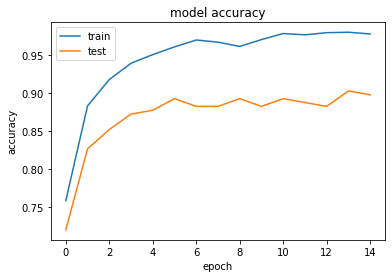

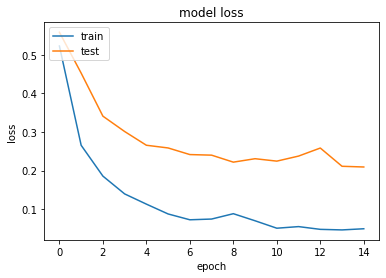

The highest validation acc is 0.9030612111091614
DenseNet 3-Fold CV:
Average Acc: 0.8740
Average Precision: 0.7814
Average recall: 0.8301
Average F1 Score: 0.7946 

INFO:tensorflow:Assets written to: Project Assets/DenseNet_Model\assets


In [4]:
train_densenet(x_train_val, y_train_val, image_size)

Accuracy for test data: 0.8608458390177354


<Figure size 504x504 with 0 Axes>

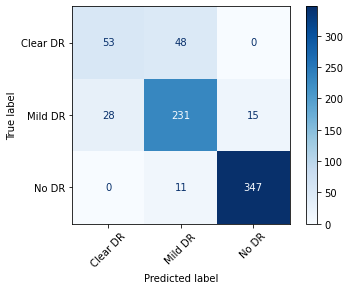

              precision    recall  f1-score   support

    Clear DR       0.65      0.52      0.58       101
     Mild DR       0.80      0.84      0.82       274
       No DR       0.96      0.97      0.96       358

    accuracy                           0.86       733
   macro avg       0.80      0.78      0.79       733
weighted avg       0.86      0.86      0.86       733



In [5]:
test_densenet(x_test, y_test)